# **Outlier Detection**

In [1]:
%load_ext autoreload
%autoreload 2

## Connectivity approach


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Read the dataset from a CSV file
cyclists_df = pd.read_csv('../dataset/cyclists_clustering.csv')
races_df = pd.read_csv('../dataset/races_clustering.csv')

cyclists_df = cyclists_df.drop(columns=["categorical_height", "weight", "height", "BMI", "best_position", "best_position_std"])
cyclists_df = cyclists_df.select_dtypes(include=[np.number])

scaler = MinMaxScaler()
cyclists_df = pd.DataFrame(scaler.fit_transform(cyclists_df), columns=cyclists_df.columns)

cyclists_with_outlier_score = cyclists_df.copy()
races_with_outlier_score = races_df.copy()

cyclists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4703 entries, 0 to 4702
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   birth_year    4703 non-null   float64
 1   cyclist_win   4703 non-null   float64
 2   strength_idx  4703 non-null   float64
 3   career_years  4703 non-null   float64
 4   km_per_year   4703 non-null   float64
dtypes: float64(5)
memory usage: 183.8 KB


In [3]:
from sklearn.neighbors import LocalOutlierFactor

k = 200

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit( cyclists_df)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists_with_outlier_score.loc[:, "lof_degree"] = outlier_degrees

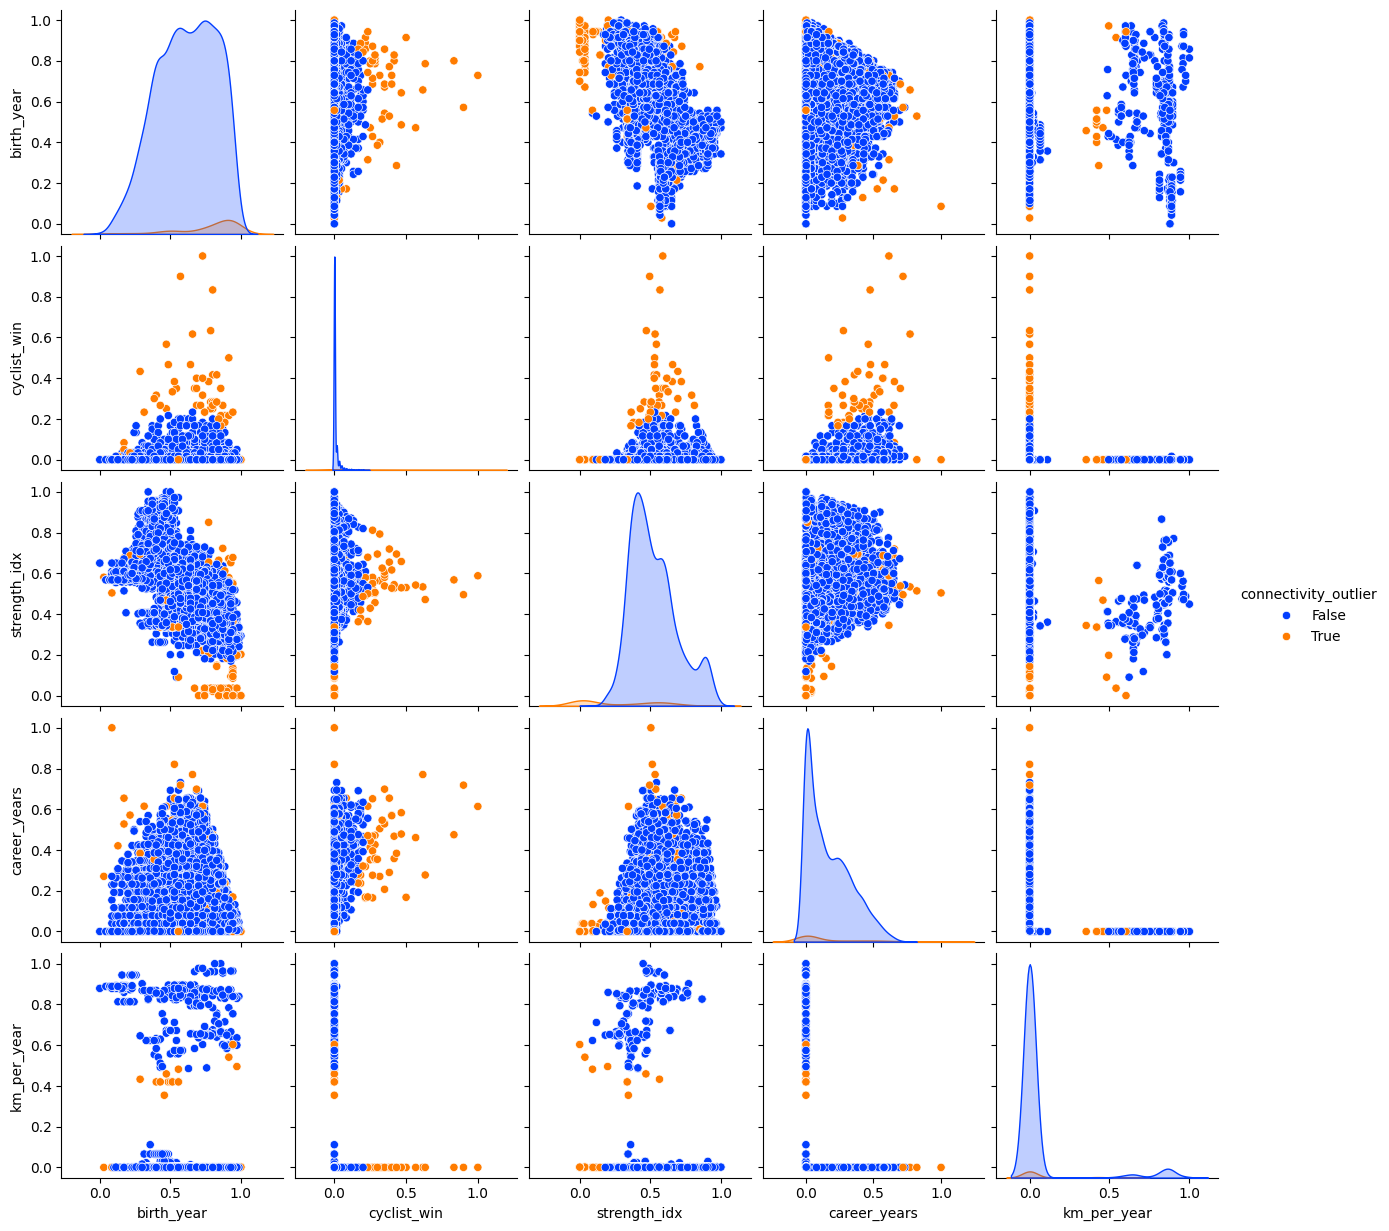

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Classify points as outliers or not
threshold = 1.5
cyclists_with_outlier_score['connectivity_outlier'] = cyclists_with_outlier_score['lof_degree'] > threshold

cyclists_with_outlier_score.drop(columns=['lof_degree'], inplace=True)

sns.pairplot(cyclists_with_outlier_score, hue='connectivity_outlier', diag_kind='kde', palette='bright')
plt.show()

cyclists_with_outlier_score.drop(columns=['connectivity_outlier'], inplace=True)


## One-class SVM


In [5]:
from sklearn.svm import OneClassSVM


# kernel = "rbf"
kernel = "linear"
# kernel = "poly"
algorithm = OneClassSVM(kernel=kernel)
algorithm.fit(cyclists_df)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(cyclists_df)
print(outlier_classification_scores)

outlier_distance_scores = algorithm.score_samples(cyclists_df)

cyclists_with_outlier_score.loc[:, "oneclass_svm_degree"] = outlier_distance_scores
cyclists_with_outlier_score.loc[:, "oneclass_svm_degree_binary"] = (outlier_classification_scores  + 1) / 2  # map to {0, 1}

print(cyclists_with_outlier_score['oneclass_svm_degree_binary'].value_counts())

if kernel == "linear":
    support_vectors = cyclists_df.iloc[algorithm.support_]
    
else:
    support_vectors = None

[-1  1  1 ... -1 -1  1]
oneclass_svm_degree_binary
0.0    2352
1.0    2351
Name: count, dtype: int64


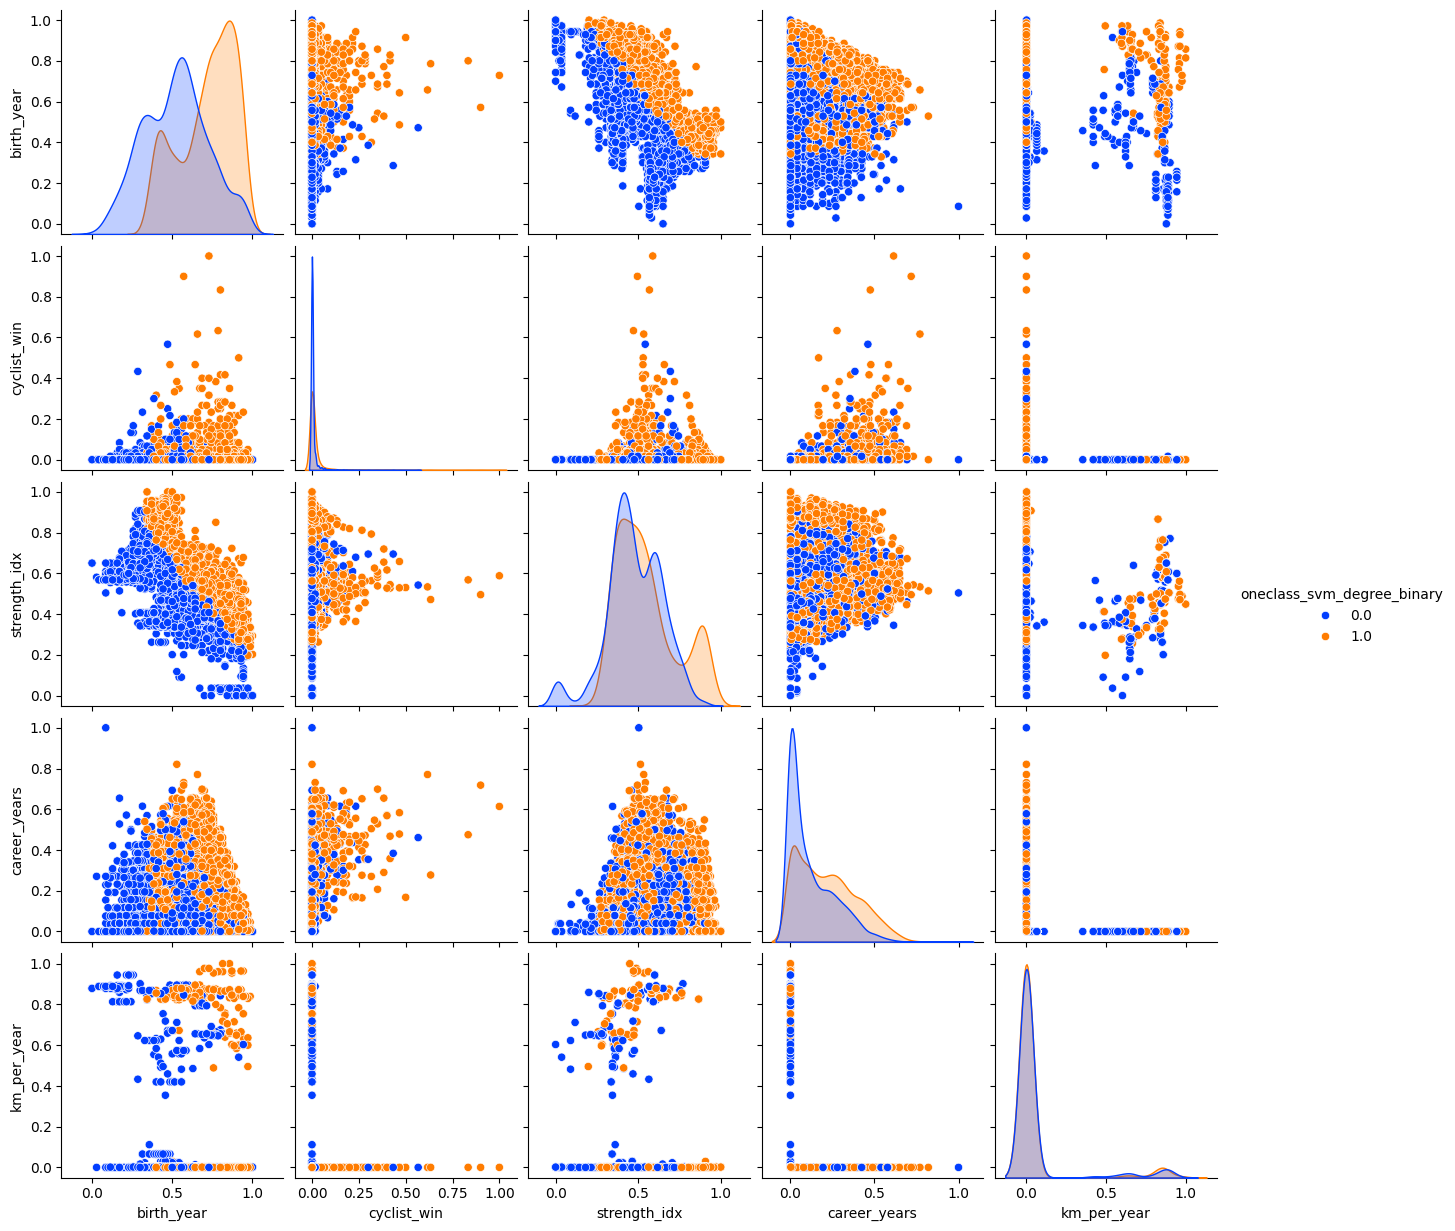

In [6]:
# Classify points as outliers or not

cyclists_with_outlier_score.drop(columns=['oneclass_svm_degree'], inplace=True)

sns.pairplot(cyclists_with_outlier_score, hue='oneclass_svm_degree_binary', diag_kind='kde', palette='bright')
plt.show()

cyclists_with_outlier_score.drop(columns=['oneclass_svm_degree_binary'], inplace=True)


## Isolation forest


In [7]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest algorithm with a lower contamination value
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
isolation_forest.fit(cyclists_df)

# Compute the outlier scores
outlier_scores = isolation_forest.decision_function(cyclists_df)
outlier_predictions = isolation_forest.predict(cyclists_df)

# Add the outlier scores to the dataframe
cyclists_with_outlier_score['isolation_forest_score'] = outlier_scores
cyclists_with_outlier_score['isolation_forest_outlier'] = (outlier_predictions == -1).astype(int)

print(cyclists_with_outlier_score['isolation_forest_outlier'].value_counts())

isolation_forest_outlier
0    4655
1      48
Name: count, dtype: int64


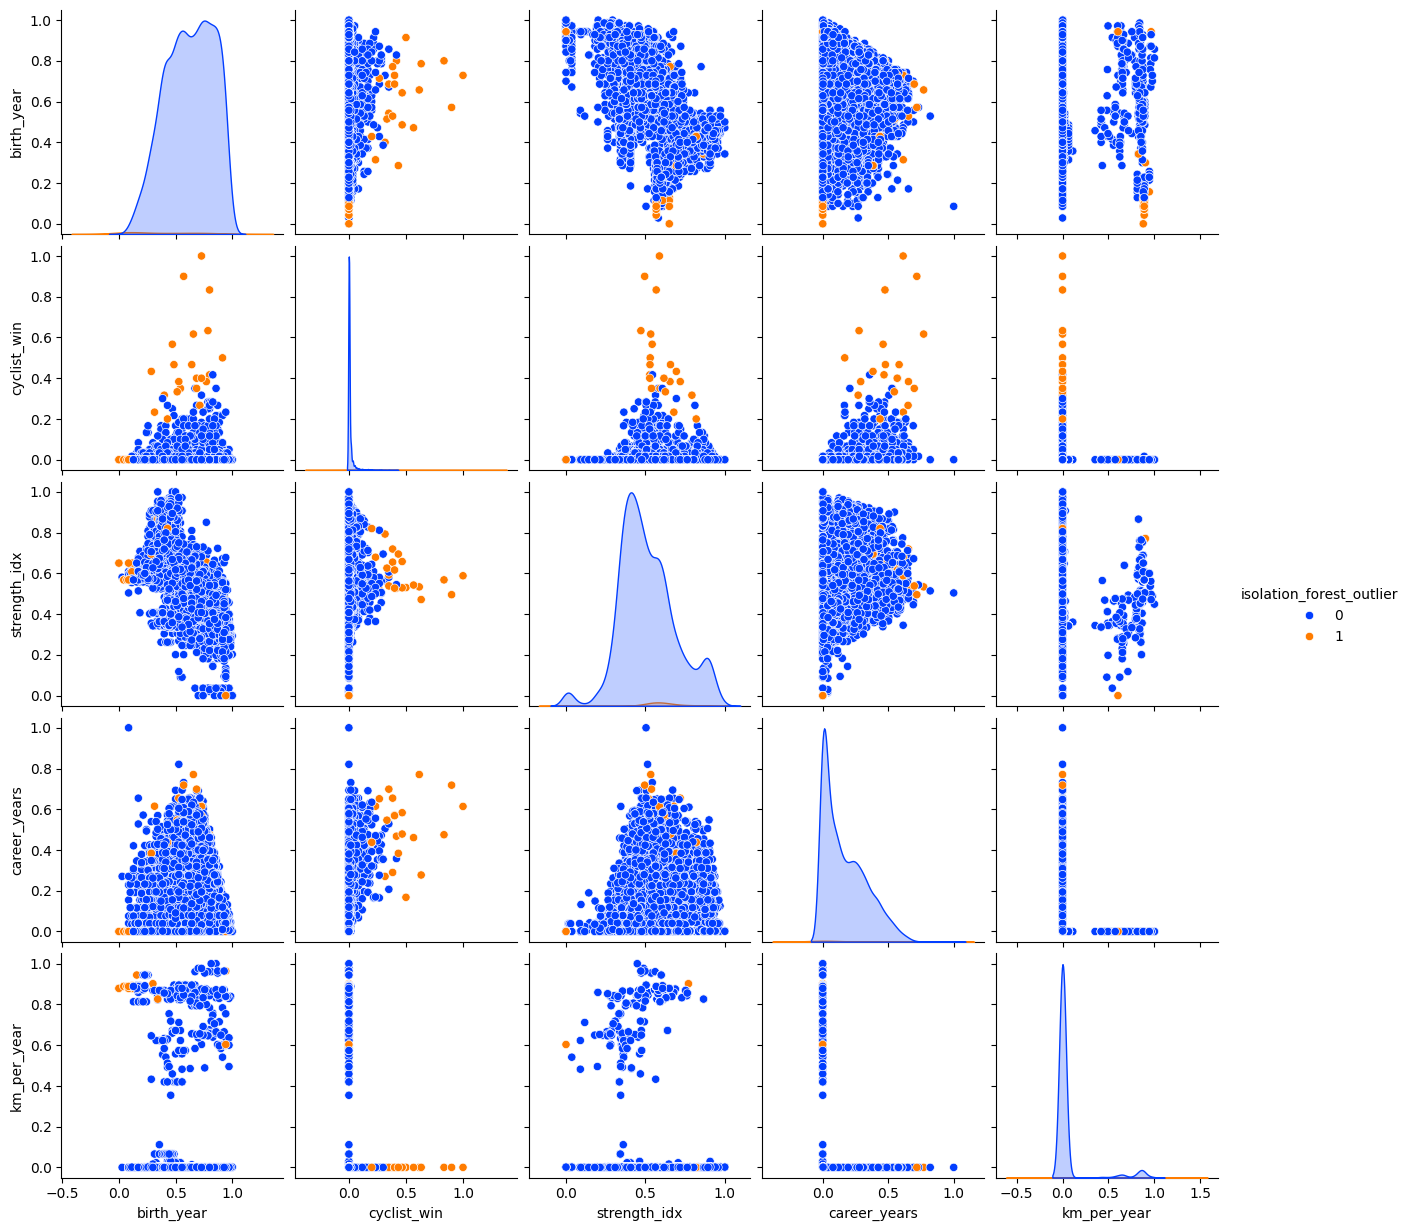

In [8]:
cyclists_with_outlier_score.drop(columns=['isolation_forest_score'], inplace=True)

sns.pairplot(cyclists_with_outlier_score, hue="isolation_forest_outlier", diag_kind='kde', palette='bright')
plt.show()